# Simulations for NJ4 single-strain model

In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

## static modelling

- see if it is possible to replicate the three observed chemostat stages of C. acetobutylicum

In [138]:
medium = list(nj4.medium.keys())
essential_rx = []

for rx in medium:
    with nj4:
        nj4.reactions.get_by_id(rx).lower_bound = 0
        sol = nj4.slim_optimize()
        if sol < 1e-6:
            essential_rx.append(rx)

print('essential metabolites:' ,[rx[3:] for rx in essential_rx])
print('essential reactions:' ,[rx for rx in essential_rx])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


essential metabolites: ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe3_e', 'fol_e', 'k_e', 'mg2_e', 'mn2_e', 'pi_e', 'so4_e', 'ura_e', 'zn2_e']
essential reactions: ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe3_e', 'EX_fol_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_pi_e', 'EX_so4_e', 'EX_ura_e', 'EX_zn2_e']


In [43]:
full_media = nj4.medium

medium = {rx:0.1 for rx in full_media.keys()}
medium['EX_xyl__D_e'] = 10
for rx in essential_rx:
    medium[rx] = 10

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [157]:
from cobra.flux_analysis import pfba, flux_variability_analysis
import pandas as pd

def get_productions(model, medium = None, reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]):
    """Get the pFBA solution, as well as (loopless) FVA solution for production reactions for a model."""
    
    with model:

        if medium is not None:
            model.medium = medium

        pfba_sol = pfba(model)
        fva_sol = flux_variability_analysis(model, reactions, loopless=True)

        output_df = pd.concat([pfba_sol.fluxes, fva_sol], axis=1, join="inner")
        return output_df.rename(columns={"fluxes": "pFBA sol"})
    
def get_specific_medium(model, specific_reactions):
    """Get a dictionary of max uptake rates for a model, with 0.1 for each reaction in the original medium, and specific custimisations."""
    
    essential_rx = ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe3_e', 'EX_fol_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_pi_e', 'EX_so4_e', 'EX_ura_e', 'EX_zn2_e']
    
    full_medium = {rx:0.1 for rx in model.medium.keys()}

    for rx in essential_rx:
        full_medium[rx] = 10

    for rx in specific_reactions.keys():
        full_medium[rx] = specific_reactions[rx]
    
    return full_medium

In [161]:
get_productions(nj4, medium=get_specific_medium(nj4, {"EX_xyl__D_e":10}))

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,pFBA sol,minimum,maximum
EX_ac_e,0.000000,0.0,0.129879
EX_but_e,0.000000,0.0,0.129879
EX_etoh_e,12.927014,0.0,15.448616
EX_btoh_e,0.112352,0.0,7.790675
EX_acetone_e,1.818308,0.0,1.818308


In [158]:
acidic_medium = get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_h_e": 1000})
get_productions(nj4, acidic_medium)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,pFBA sol,minimum,maximum
EX_ac_e,0.000000,0.0,0.129879
EX_but_e,0.000000,0.0,0.129879
EX_etoh_e,12.927014,0.0,15.448616
EX_btoh_e,0.112352,0.0,7.790675
EX_acetone_e,1.818308,0.0,1.818308


In [162]:
from cobra.flux_analysis import pfba

with nj4:
    acid_medium = get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_h_e":1000})
    nj4.medium = acid_medium
    
    summary = nj4.summary()
    solution = nj4.optimize()
    pfba_solution = pfba(nj4)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [5]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
ala__L_e,EX_ala__L_e,0.1,3,0.52%
arg__L_e,EX_arg__L_e,0.1,6,1.04%
asp__L_e,EX_asp__L_e,0.1,4,0.69%
ca2_e,EX_ca2_e,0.001026,0,0.00%
cl_e,EX_cl_e,0.001026,0,0.00%
cobalt2_e,EX_cobalt2_e,1.972E-05,0,0.00%
cu2_e,EX_cu2_e,0.0001398,0,0.00%
cys__L_e,EX_cys__L_e,0.1,3,0.52%
fe2_e,EX_fe2_e,0.001324,0,0.00%
fe3_e,EX_fe3_e,0.00154,0,0.00%


- an amino acid conundrum, there are AAs present in the yeast-extract, but probably in really small amounts...
- is consuming xylose, however not as sole carbon-source due to AAs...
- is secreting ethanol, acetone, and butanol. which should be co-expressed in solventogenetic phase!

In [6]:
import escher
from escher import Builder

builder = Builder(map_json='new_map.json', model=nj4, height=600)

In [163]:
builder.reaction_data = pfba_solution.fluxes

In [164]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [167]:
def read_production_rates(sol):
    """Returns some metrics from a cobra solution in an easily readable format."""
    production_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]
    print('Production fluxes:')
    print(sol.fluxes[production_reactions])

In [169]:
read_production_rates(solution)
read_production_rates(pfba_solution)

Production fluxes:
EX_but_e         0.000000
EX_ac_e          0.000000
EX_etoh_e       15.325104
EX_btoh_e        0.112352
EX_acetone_e     0.019741
Name: fluxes, dtype: float64
Production fluxes:
EX_but_e         0.000000
EX_ac_e          0.000000
EX_etoh_e       12.927014
EX_btoh_e        0.112352
EX_acetone_e     1.818308
Name: fluxes, dtype: float64


- model behaving as we would expect in solventogenic phase
- there are likely several optimal solutions here, should try to utilise FVA in some way to look into the solution space

In [170]:
get_productions(nj4, medium=get_specific_medium(nj4, {"EX_xyl__D_e":10, "EX_h_e":1000}))

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,pFBA sol,minimum,maximum
EX_ac_e,0.000000,0.0,0.129879
EX_but_e,0.000000,0.0,0.129879
EX_etoh_e,12.927014,0.0,15.448616
EX_btoh_e,0.112352,0.0,7.790675
EX_acetone_e,1.818308,0.0,1.818308


- the model has the highest capability for ethanol production, and low capability for acid production
    - suggests and affinity for alcoholgenesis > solventogenesis > acidogenesis
- when increasing the possible H+ uptake rate, the possibility for solventogenesis increases!

## dynamic modelling

In [70]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

nj4_med = media_db[media_db["medium"] == "nj4_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in nj4_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}
added_metabilotes["xyl__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose

In [71]:
from utils.comets_functions import single_strain

sim = single_strain(model=nj4, medium=added_metabilotes, sim_time=40)


Running COMETS simulation ...
Done!


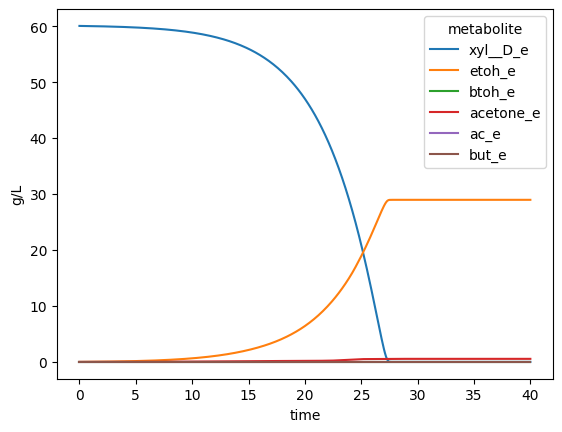

In [72]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "acetone_e"]

plot_metabolites(sim, metabolites)

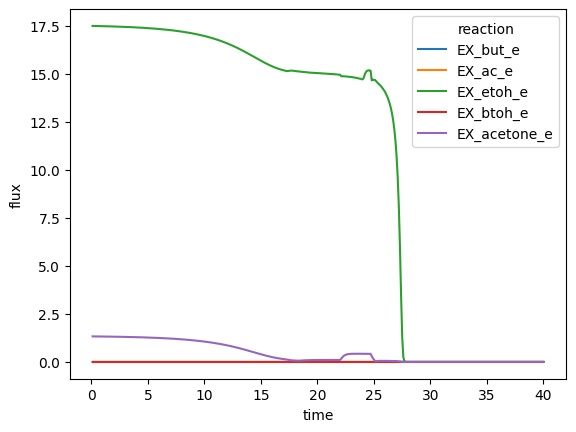

In [73]:
plot_reaction_flux(sim, production_reactions, "NJ4")

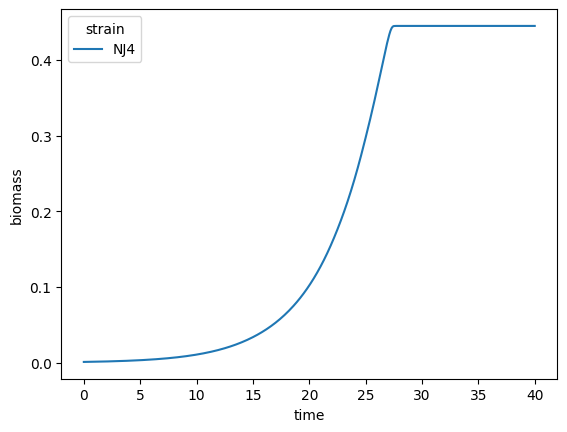

In [74]:
plot_biomass(sim)

In [112]:
import escher
from escher import Builder

builder = Builder(map_json='new_map.json', model=nj4, height=600)

In [114]:
from time import sleep
from tqdm.notebook import tqdm

fluxes = sim.get_species_exchange_fluxes("NJ4")
fluxes = sim.fluxes_by_species["NJ4"].drop(columns=["x", "y"])
melted_fluxes = fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    builder.reaction_data = flux_series
    sleep(0.1)

  0%|          | 0/400 [00:00<?, ?it/s]

In [113]:
builder

Builder(height=600)